<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2022/blob/main/ChemicalMasterEquation_WorkBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## **Tutorial 4.1: Solving the Chemical Master Equation using the Finite State Projection**

----------
## UQBio Summer School 2022
--------------

```
Instructor: Michael May
Author: Michael May
Contact Info: michaelpmay@live.com

Copyright (c) 2022 Dr. Brian Munsky. 
Dr. Luis Aguilera, Will Raymond
Colorado State University.
Licensed under BSD-3-Clause license.



---
# *Learning Objectives*

---
The Finite State Projection (FSP) can be used to model temporal dynamics of Master Equation dynamics for chemical reactions. 

After this workbook students should be able to:
*   Determine the ensembe of states of a system
*   Write the infinitesimal generator from the propensity and emsemble
*   Calculate the time series solution of the FSP using the matrix exponential
*   Calculate the probability-current of a state of interest

In [ ]:
#@markdown Preliminary Codes
!wget -q --recursive -np bitbio.org/cme/ -P /content/ --accept py, JPG, jpg --reject index*
!mv bitbio.org/cme/* .
!rm -r bitbio.org/
from utility.Model import *
from utility.Solvers import *
from utility.preallocate import preallocate
from utility.ModelBuilder import *
import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.display import Image
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
figSize=600

mv: cannot move 'bitbio.org/cme/figures' to './figures': Directory not empty
mv: cannot move 'bitbio.org/cme/presentation' to './presentation': Directory not empty
mv: cannot move 'bitbio.org/cme/utility' to './utility': Directory not empty


---

**Background**

---

The SSA simulation that we saw last week is very useful for quickly simulating the stochastic behavior of systems, but the SSA only *samples* from a *true distribution*. The finitie state projection (FSP) instead solves how probability flows over the set of possible chemical states and can be used to solve for this distribution.

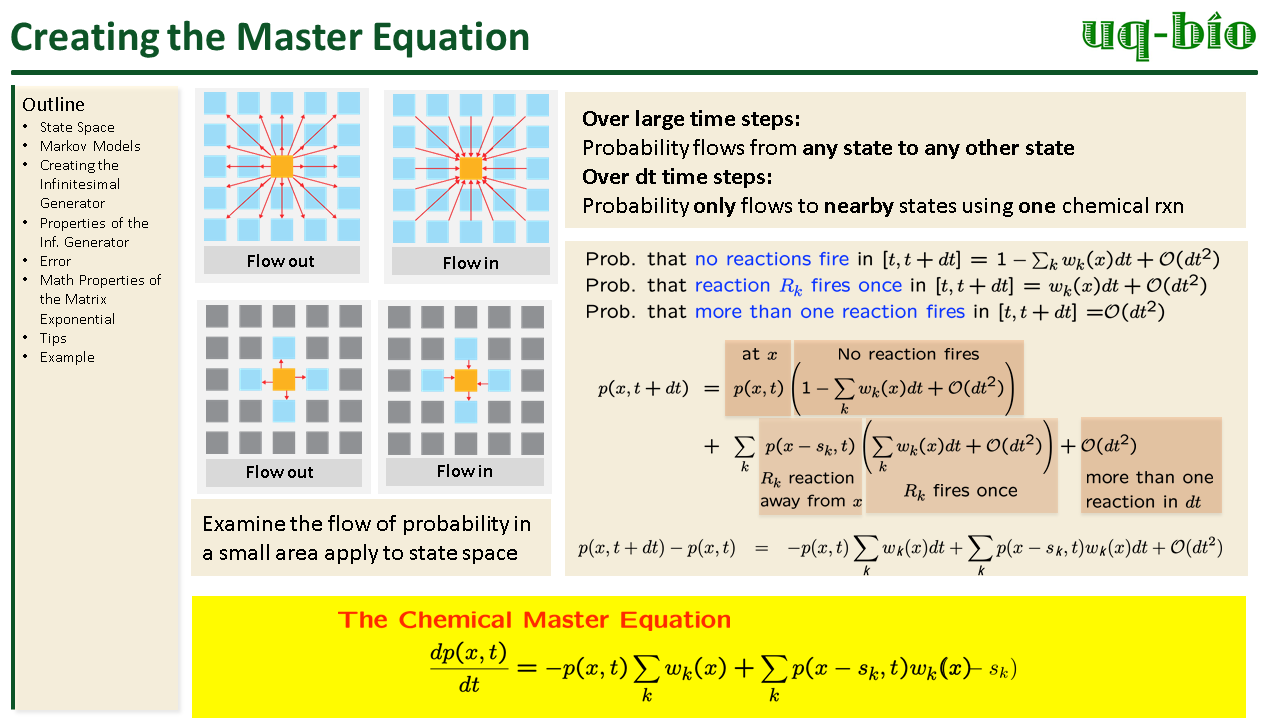

In [ ]:
#@title Creating the Master Equation
Image('/content/presentation/Slide9.PNG',width=figSize)

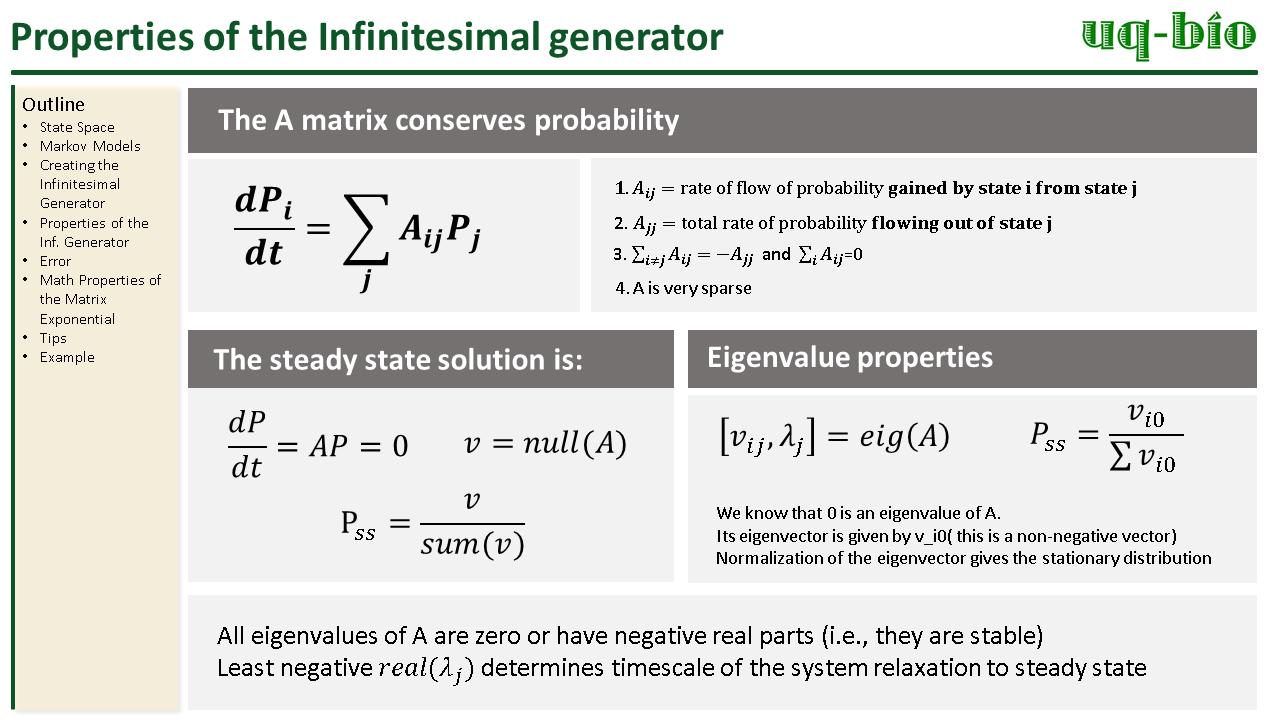

In [ ]:
#@title Math Properties of the Infinitesimal Generator
Image('/content/presentation/Slide15.PNG',width=figSize)

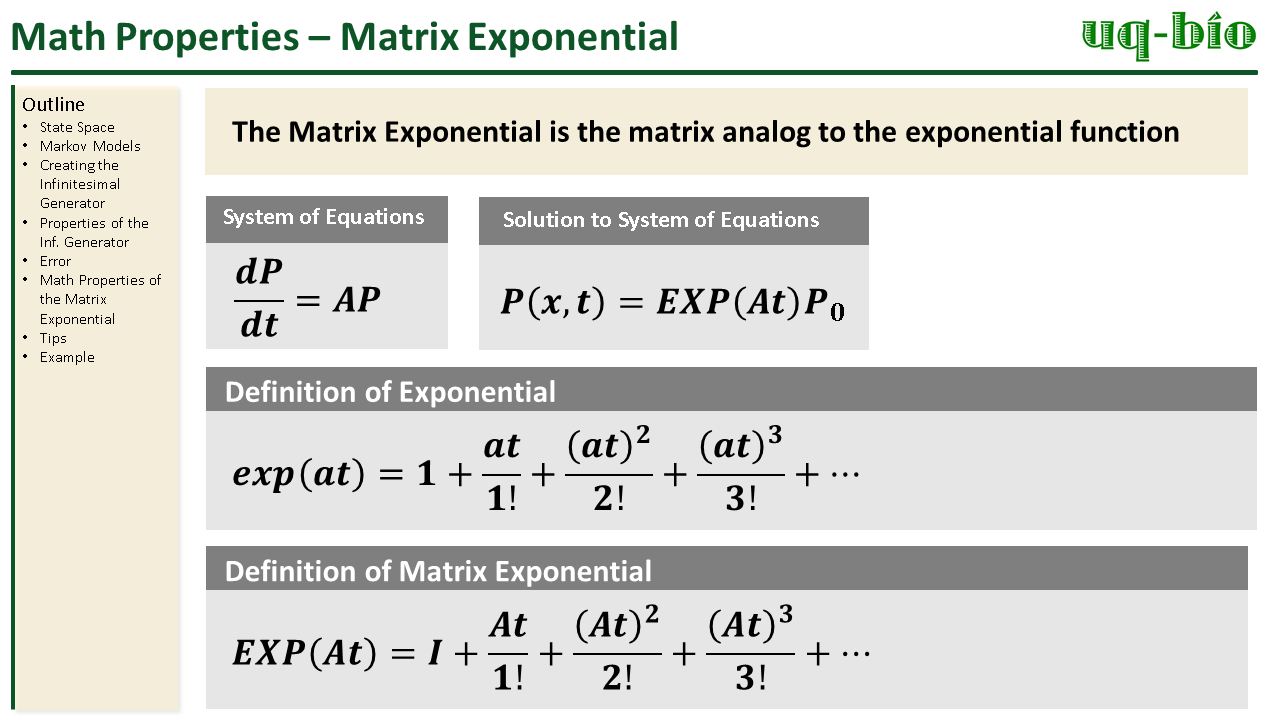

In [ ]:
#@title Solution to System of Equations
Image('/content/presentation/Slide19.PNG',width=figSize)

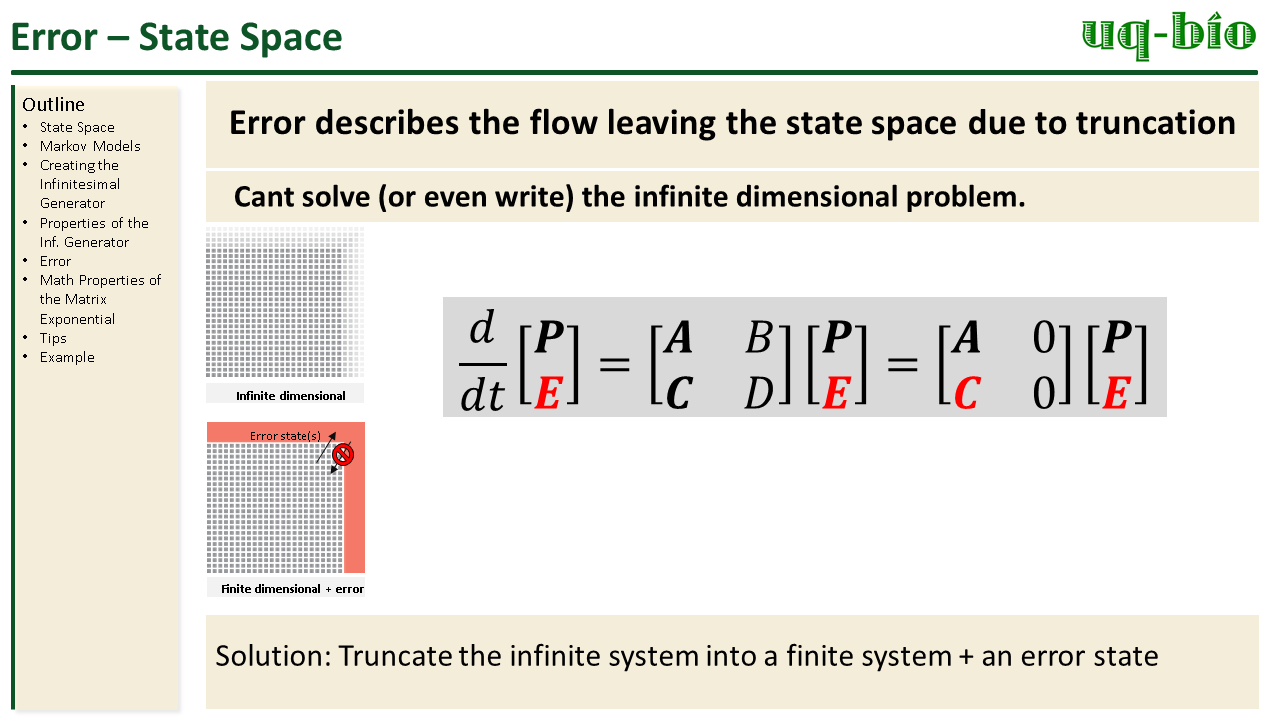

In [ ]:
#@title Error State
Image('/content/presentation/Slide17.PNG',width=figSize)

---
# **Problem 1: Birth-Decay Process for a Protein of Interest**
A birth decay process for an arbirary protein is modeled with birth propensity $k_1$ and degraded with propensity $k_2x_1$. Calulate the FSP of the system using the state space of 0 to 4 molecules and an error state of 5 or more molcules, 
> 1. Use the Birth-Decay model with 5 states + error to fill out the A1 and A2 matricies below. Use only the birth equations for A1 and only decay equations for A2.
1. Use a `for` loop to create the A matrix for a large number of states.
1. Check that the column sum of A is a 0 vector.
1. Use the matrix exponential to solve for P(x,t) over a set of linearly spaced time points from 0 to 10 in 100 steps, and with the a delta distribution located at x=0 as the initial condition
1. Calculate the total ammount of probability in P and the total ammount of probability in E versus time. Make plots of Total P and Toal E versus time
1. Solve for the FSP and the SSA using k1=1, k2=0.05, and a time span from 0 to 50 minutes. Then, plot the FSP and the SSA together using pcolor and plot.

---

In [ ]:
#@title
Image('/content/figures/BirthDecay.JPG',width=figSize)

In [ ]:
#@title
Image('/content/figures/Birth-Decay.png',width=figSize)

**Part 1: Use the Birth-Decay model with 5 states + error to fill out the A1 and A2 Matricies below.**

$\frac{d}{dt}\begin{pmatrix}P\\E\end{pmatrix}=\begin{pmatrix}A&0\\C&0\end{pmatrix}P$

In [33]:
# The location of each element in A tells you where the probability is from and 
# where it is going to

#          P0   P1   P2   P3   P4   E

#dP0/dt    A00  A01  A02  A03  A04  0
#dP1/dt    A10  A11  A12  A13  A14  0
#dP2/dt    A20  A21  A22  A23  A24  0
#dP3/dt    A30  A31  A32  A33  A34  0
#dP4/dt    A40  A41  A42  A43  A44  0
#dE/dt     CE0  CE1  CE2  CE3  CE4  0

k1=.1
k2=.05
A1=[[-k1,   0,     0,     0,   0,   0],
    [+k1, -k1,     0,     0,   0,   0],
    [0,   +k1,   -k1,     0,   0,   0],
    [0,     0,   +k1,   -k1,   0,   0],
    [0,     0,     0,   +k1, -k1,   0],
    [0,     0,     0,     0, +k1, -k1]]

A2=[[0,   +1*k2,       0,      0,     0,   0],
    [0,   -1*k2,   +2*k2,      0,     0,   0],
    [0,       0,   -2*k2,  +3*k2,     0,   0],
    [0,       0,       0,  -3*k2, +4*k4,   0],
    [0,       0,       0,      0, -4*k4,   0],
    [0,       0,       0,      0,     0,   0]]
A=np.array(A1+A2)
np.sum(A, axis=0)

NameError: ignored

**Part 2. Use a for loop to create an infinitesimal generator of size N by N, with N an an arbirary sized integer**

In [ ]:
#@title
Image('/content/presentation/Slide25.PNG',width=figSize)

In [35]:
# Start by defing the relevant parameters
k1=1           # birth rate parameter
k2=.05         # death rate parameter 
N=20           # number of states in the state space+error, which also determines the size of the A matrix
# Preallocate the A matrix, which is always square
A=np.zeros([N,N])
# Step through each column of the matrix and add the proper terms taking into account both birth and decay
for i in range(N):
  if i<(N-1):
    A[i,i]= A[i,i]-k1                     # subtract the propensity of probability leaving due to creation from that state
    A[i+1,i]= k1                   # add the propensity of probability arriving to the next state
  if i>=1:
    A[i-1,i]= k2*i                   # subtract the propensity of probability leaving due to decay from that state
    A[i,i]= A[i,i]- k2*i                     # subtract the propensity of probability arring due to decay from the previous state
A[:,-1]=0
print(A)
print(np.sum(A))

[[-1.    0.05  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.   -1.05  0.1   0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.   -1.1   0.15  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.   -1.15  0.2   0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.   -1.2   0.25  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.   -1.25  0.3   0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.   -1.3   0.35  0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.   -1.35  0.4   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0

---
**Part 3: Check that the column sum is zero**

---

In [37]:
# Perform the columnsum of A below

np.sum(A, axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11022302e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.11022302e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.11022302e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.11022302e-16, 0.00000000e+00])

---
**Part 4. Use the matrix exponential to solve for P(x,t) over a set of linearly spaced time points from 0 to 10 in 100 steps, and with the a delta distribution located at x=0 as the initial condition**

The solution of P(x,t) is given by

$P(x,t)=EXPM(At)*P_0$

---

[]

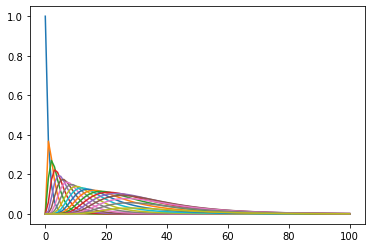

In [38]:
# Define the initial probability distribution by preallocaitng a zero array and 
# adding a one where the SSA's start at, but you can pick any initialProbability 
# as long as initial Probability sums to one and each elemt is greater than 0.
initialProbability = np.zeros([N])
initialProbability[0]=1

# use a linearly spaced set of time points from 0 to 100 in 100 steps
timeSpan = np.linspace(0,100,100)

# preallocate a matrix to save the history of each state
probabilityHistory=np.zeros([len(initialProbability),len(timeSpan)])
for i in range(len(timeSpan)):
  currentState = scipy.linalg.expm(A * timeSpan[i]) @ initialProbability                           #P(x,t)=EXPM(A*t)*Po
  probabilityHistory[:,i]=currentState
plt.plot(timeSpan,probabilityHistory[:-1,:].T)
[]

**Part 5. Calculate the total ammount of probability in P and the total ammount of probabilit in E versus time. Make plots of Total P and Toal E versus time**


In [39]:
# Make plots of the total probability in the error state over time, and the sum 
# of total P over time
sumP = np.sum(probabilityHistory[0:-1],axis=0)
sumE = probabilityHistory[-1:, :].T

fig, ax = plt.subplots(1,1)
ax.plot(timeSpan, sumP)
ax.plot(timeSpan, sumE)

**Part 6. Solve for the FSP and the SSA using k1=1, k2=0.05, and a time span from 0 to 50 minutes. Then, plot the FSP and the SSA together using pcolor and plot.**

In [32]:
# Define the Parameters
# the time vector is linearly spaced numbers between 0 and 50
timeSpan = np.linspace(0,50)  
# the initial state of the SSA and FSP has all trajectories starting at 0                                       
initialState=np.array([0])   
# REACTIONS:
# R1 0 -> x[0]
# R2 x[0] -> 0
stoichiometry = np.array([[+1, 
                           -1]])                            
def propensity(x,t,k):
  rate = np.array([k[0], k[1] * x[0]])
  return rate

# parameter vector defines k[0] and k[1]                                
parameters=np.array([1,.05])                                       

# Solve for the SSA using the function
(ssaTime,ssaState)=solveSSA(timeSpan,initialState,stoichiometry,propensity,parameters)

# Solve for the FSP using the function
(fspTime,fspState)=solveFSP(timeSpan,initialState,stoichiometry,propensity,parameters,[50])

# Use matlplotlib's pcolor to overlay the SSA solution over the FSP solution


IndexError: ignored

---

# **Problem 2: Extinction Explosion of an Island of Rabbits**


A population of rabits inhabit an island whose popluation over time folows a stochastic trajectory(SSA). If the population of rabits ever hits zero or one by random chance, no rabits can ever be made again and the population is destined to be zero forerver. Conversely, when the number of rabits becomes large, the rate of birth exceedes the rate of death and the population is destined to explode to infinte rabbits. There are two desitines for the stochastic rabbit poulation explosion or extinction. 

> 1.  Create the Extinction Explosion infinitesimal generator for an arbitrary number of states using the figure below. Let kappa=0.05/19, and gamma = 0.05 using the figure below.
1.  Solve for the time dynamics of the system using the matrix Exponential. What is the probability of explosion and extinction after a long time?
1.  Solve for the 0 nullspace of the model. Do you notice anyting strange?

---

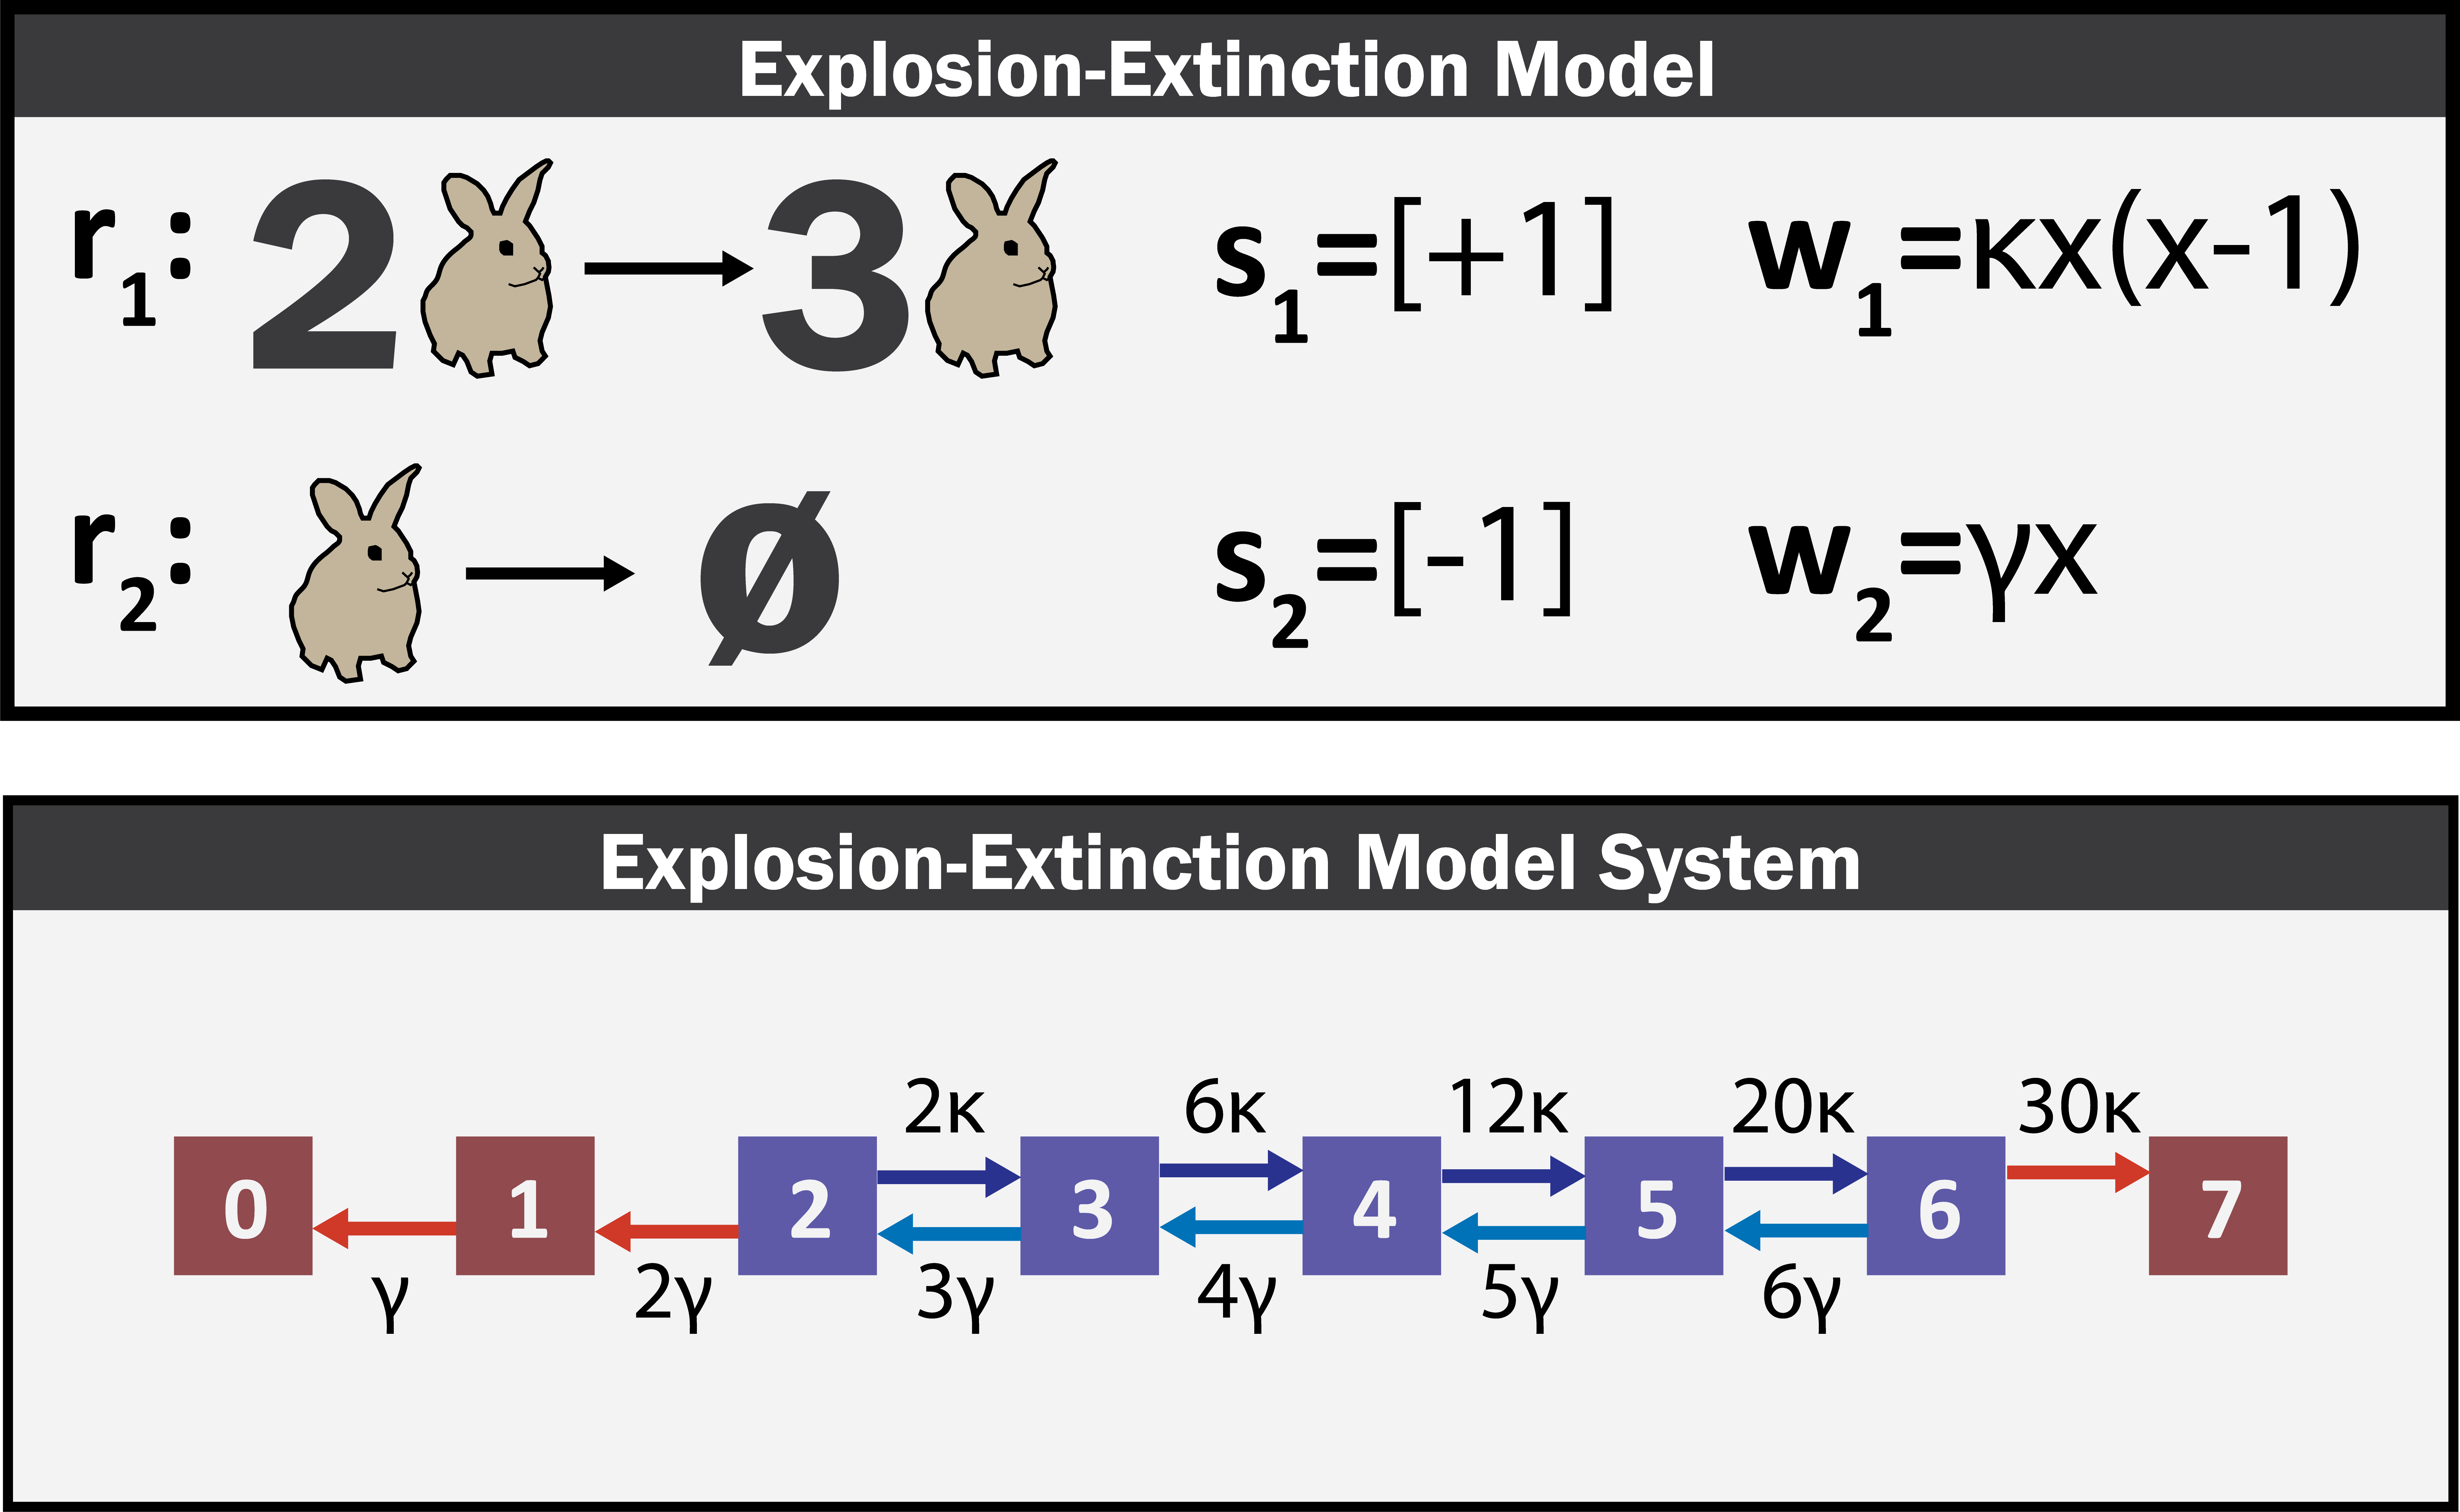

In [40]:
#@title
Image('/content/figures/ExtinctionExplosion.png',width=figSize)

[]

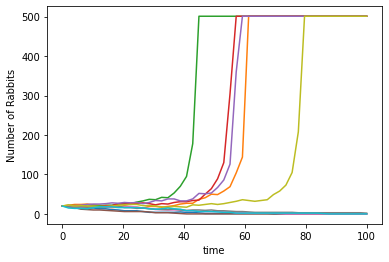

In [49]:
# This function makes 10 SSA Simulations of the extinction-explosion Model with 
# k=.05/19 and g=.05
makeExplosionExtinctionSSAPlot()
plt.ylabel('Number of Rabbits')
plt.xlabel('time')
[]

**Part 1. Create the Extinction Explosion Model Infintesimal Generator for an arbitrary number of states.**



In [50]:
# define the k and g parameters in the model
k=0.05/19
g=0.05

# define the numer of states used in the FSP
numStates=100 
# Preallocate the A Matrix
A=np.zeros([numStates,numStates])
for i in range(numStates):
  if i<(numStates-1):          # Do not add a propensity to create at the last step
    A[i+1,i]= k*i*(i-1)                 # add the propensity to create a molecule to the next state
    A[i,i]= A[i,i] - k*i*(i-1)                   # subtract the ammount of probability lost in the current state
  if i>=1 and i<(numStates-1): # Do not add propensity to decay when X=0 or X=N
    A[i-1,i]= g*i                 # add the propensity to decay to the previous state
    A[i,i]= A[i,i]  - g*i                   # add the propensity to decay to the previous state

**Part 2. Solve for the time dynamics of the system using EXPM with a time span of 0 to 300 minutes, and an initial condition of 20 rabbits.**



In [72]:
# Define the set of timepoints used as linearly spaced numbers from 0 to 300 using 100 time points
timeSpan = np.linspace(0,300,100) 
time = np.linspace(0,300,100) 
# Define the initial probability of the system. We want all the probability centered on a single location. 
# This is equivalent of running many SSA's starting at that state.           
initialProbability = np.zeros([numStates])
initialProbability[20]=1

# preallicate the matrix that stores the hisory of the probability distribution
probabilityHistory=np.zeros([numStates,len(timeSpan)])
for i in range(len(timeSpan)):
  currentState = scipy.linalg.expm(A*timeSpan[i]) @ initialProbability                        # Analyze P(x,t)=Expm(At)Po
  probabilityHistory[:,i]=currentState# write the solution at t(i) into the state history  
# Plot both the sink states below              
plt.plot(timeSpan,probabilityHistory[0,:])
plt.plot(timeSpan,probabilityHistory[-1,:])
plt.legend(['Probability of Extinction','Probability of Explosion'])
plt.xlabel('time')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

**Part 2.1:** Calculate the probability-current (dPi/dt) of exploding or extinction

> Indented block



Text(0, 0.5, 'Density')

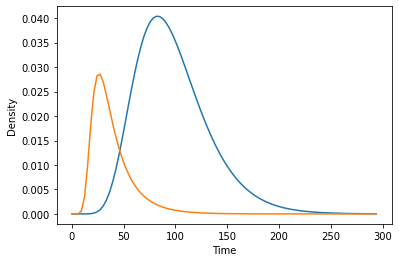

In [73]:
# Use this space to calculate the probability-flow into the explostion state or the extinction state
probabilityOfExplodingOverTime = probabilityHistory[-1,:]
probabilityOfExtinctionOverTime = probabilityHistory[0,:]
dt = timeSpan[1] - timeSpan[0]
pCurrentOfExploding = (probabilityOfExplodingOverTime[2:] - probabilityOfExplodingOverTime[:-2]) / dt
pCurrentOfExtinction = (probabilityOfExtinctionOverTime[2:] - probabilityOfExtinctionOverTime[:-2])

plt.plot(timeSpan[:-2],pCurrentOfExtinction)
plt.plot(timeSpan[:-2],pCurrentOfExploding)
plt.xlabel('Time')
plt.ylabel('Density')


**Part 2.2:** What is the probability of not reaching any fate at time t.

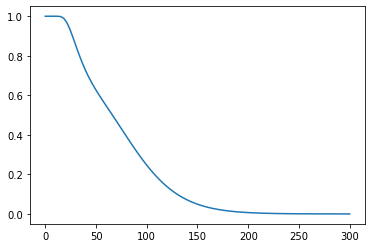

In [74]:
# Use this space to calculate the probability of not exploding or extincting
probabilityOfNoFate = 1-probabilityOfExplodingOverTime-probabilityOfExtinctionOverTime
plt.plot(timeSpan,probabilityOfNoFate)


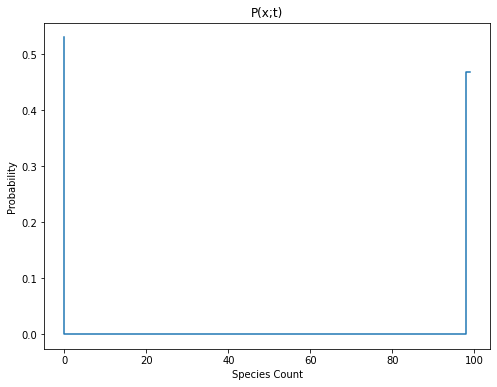

In [79]:
from os import times
# @title
fig=plt.figure(figsize=(8,6))
ax = plt.axes()
def frame(w):
    ax.clear()
    global timeSpan,state,numStates
    plt.title("P(x;t)")
    ax.set_xlabel('Species Count')
    ax.set_ylabel('Probability')
    plot=ax.step(range(numStates),probabilityHistory[:,w])
    return plot
anim = animation.FuncAnimation(fig, frame, frames=len(timeSpan), blit=True, repeat=True)
anim

**Part 3:** Use this area to calculate the nullspace of A

In [81]:
# Calculate the nullspace of A here

v = scipy.linalg.null_space(A)
print(v)


[[ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -6.42479639e-14]
 [ 0.00000000e+00 -3.53117026e-14]
 [ 0.00000000e+00 -2.69037446e-14]
 [ 0.00000000e+00 -2.29432227e-14]
 [ 0.00000000e+00 -2.06762524e-14]
 [ 0.00000000e+00 -1.88930877e-14]
 [ 0.00000000e+00 -1.65394830e-14]
 [ 0.00000000e+00 -1.25231223e-14]
 [ 0.00000000e+00 -6.16858532e-15]
 [ 0.00000000e+00  2.01305378e-15]
 [ 0.00000000e+00  9.94983339e-15]
 [ 0.00000000e+00  1.47339650e-14]
 [ 0.00000000e+00  1.43773706e-14]
 [ 0.00000000e+00  9.45582424e-15]
 [ 0.00000000e+00  3.17760296e-15]
 [ 0.00000000e+00 -5.61911321e-16]
 [ 0.00000000e+00  1.25898039e-16]
 [ 0.00000000e+00  3.80399118e-15]
 [ 0.00000000e+00  6.94112695e-15]
 [ 0.00000000e+00  6.77480733e-15]
 [ 0.00000000e+00  3.46300994e-15]
 [ 0.00000000e+00 -2.46772224e-16]
 [ 0.00000000e+00 -1.47952518e-15]
 [ 0.00000000e+00  3.39375331e-16]
 [ 0.00000000e+00  3.15901741e-15]
 [ 0.00000000e+00  4.25418425e-15]
 [ 0.00000000e+00  2.64090845e-15]
 [ 0.00000000e+00 -1

---
# **Problem 3: Protein Bursts due to Gene Regulation**
The Gene bursting model can be rewritten into a two state model where the first state is the nuber of active gene and the second state is the number of protein. Use the altered two state model to solve for the questions below.
> 1. Create a model by defining time, stoichimetry, propensity and initial state, and parameters, and solve for the model using solveFSP(time,initialState,stoichiometry, propensity, parameters,sink=True, isTimeVarying=False). Use the sliders below to see how time, parameters and state space size changes the Error.
1. Use makeInfGenerator() to create an inf Generator of the bursting gene model, and use the function to calulate the steady state and the relaxation time of the system. Change the sink property of the function and resolve for the steadystate solution.
1. Use the solution at the final time point to solve for the probability of Gene on, the probability of the Gene off, and the total ammount of protein in the system. 

---

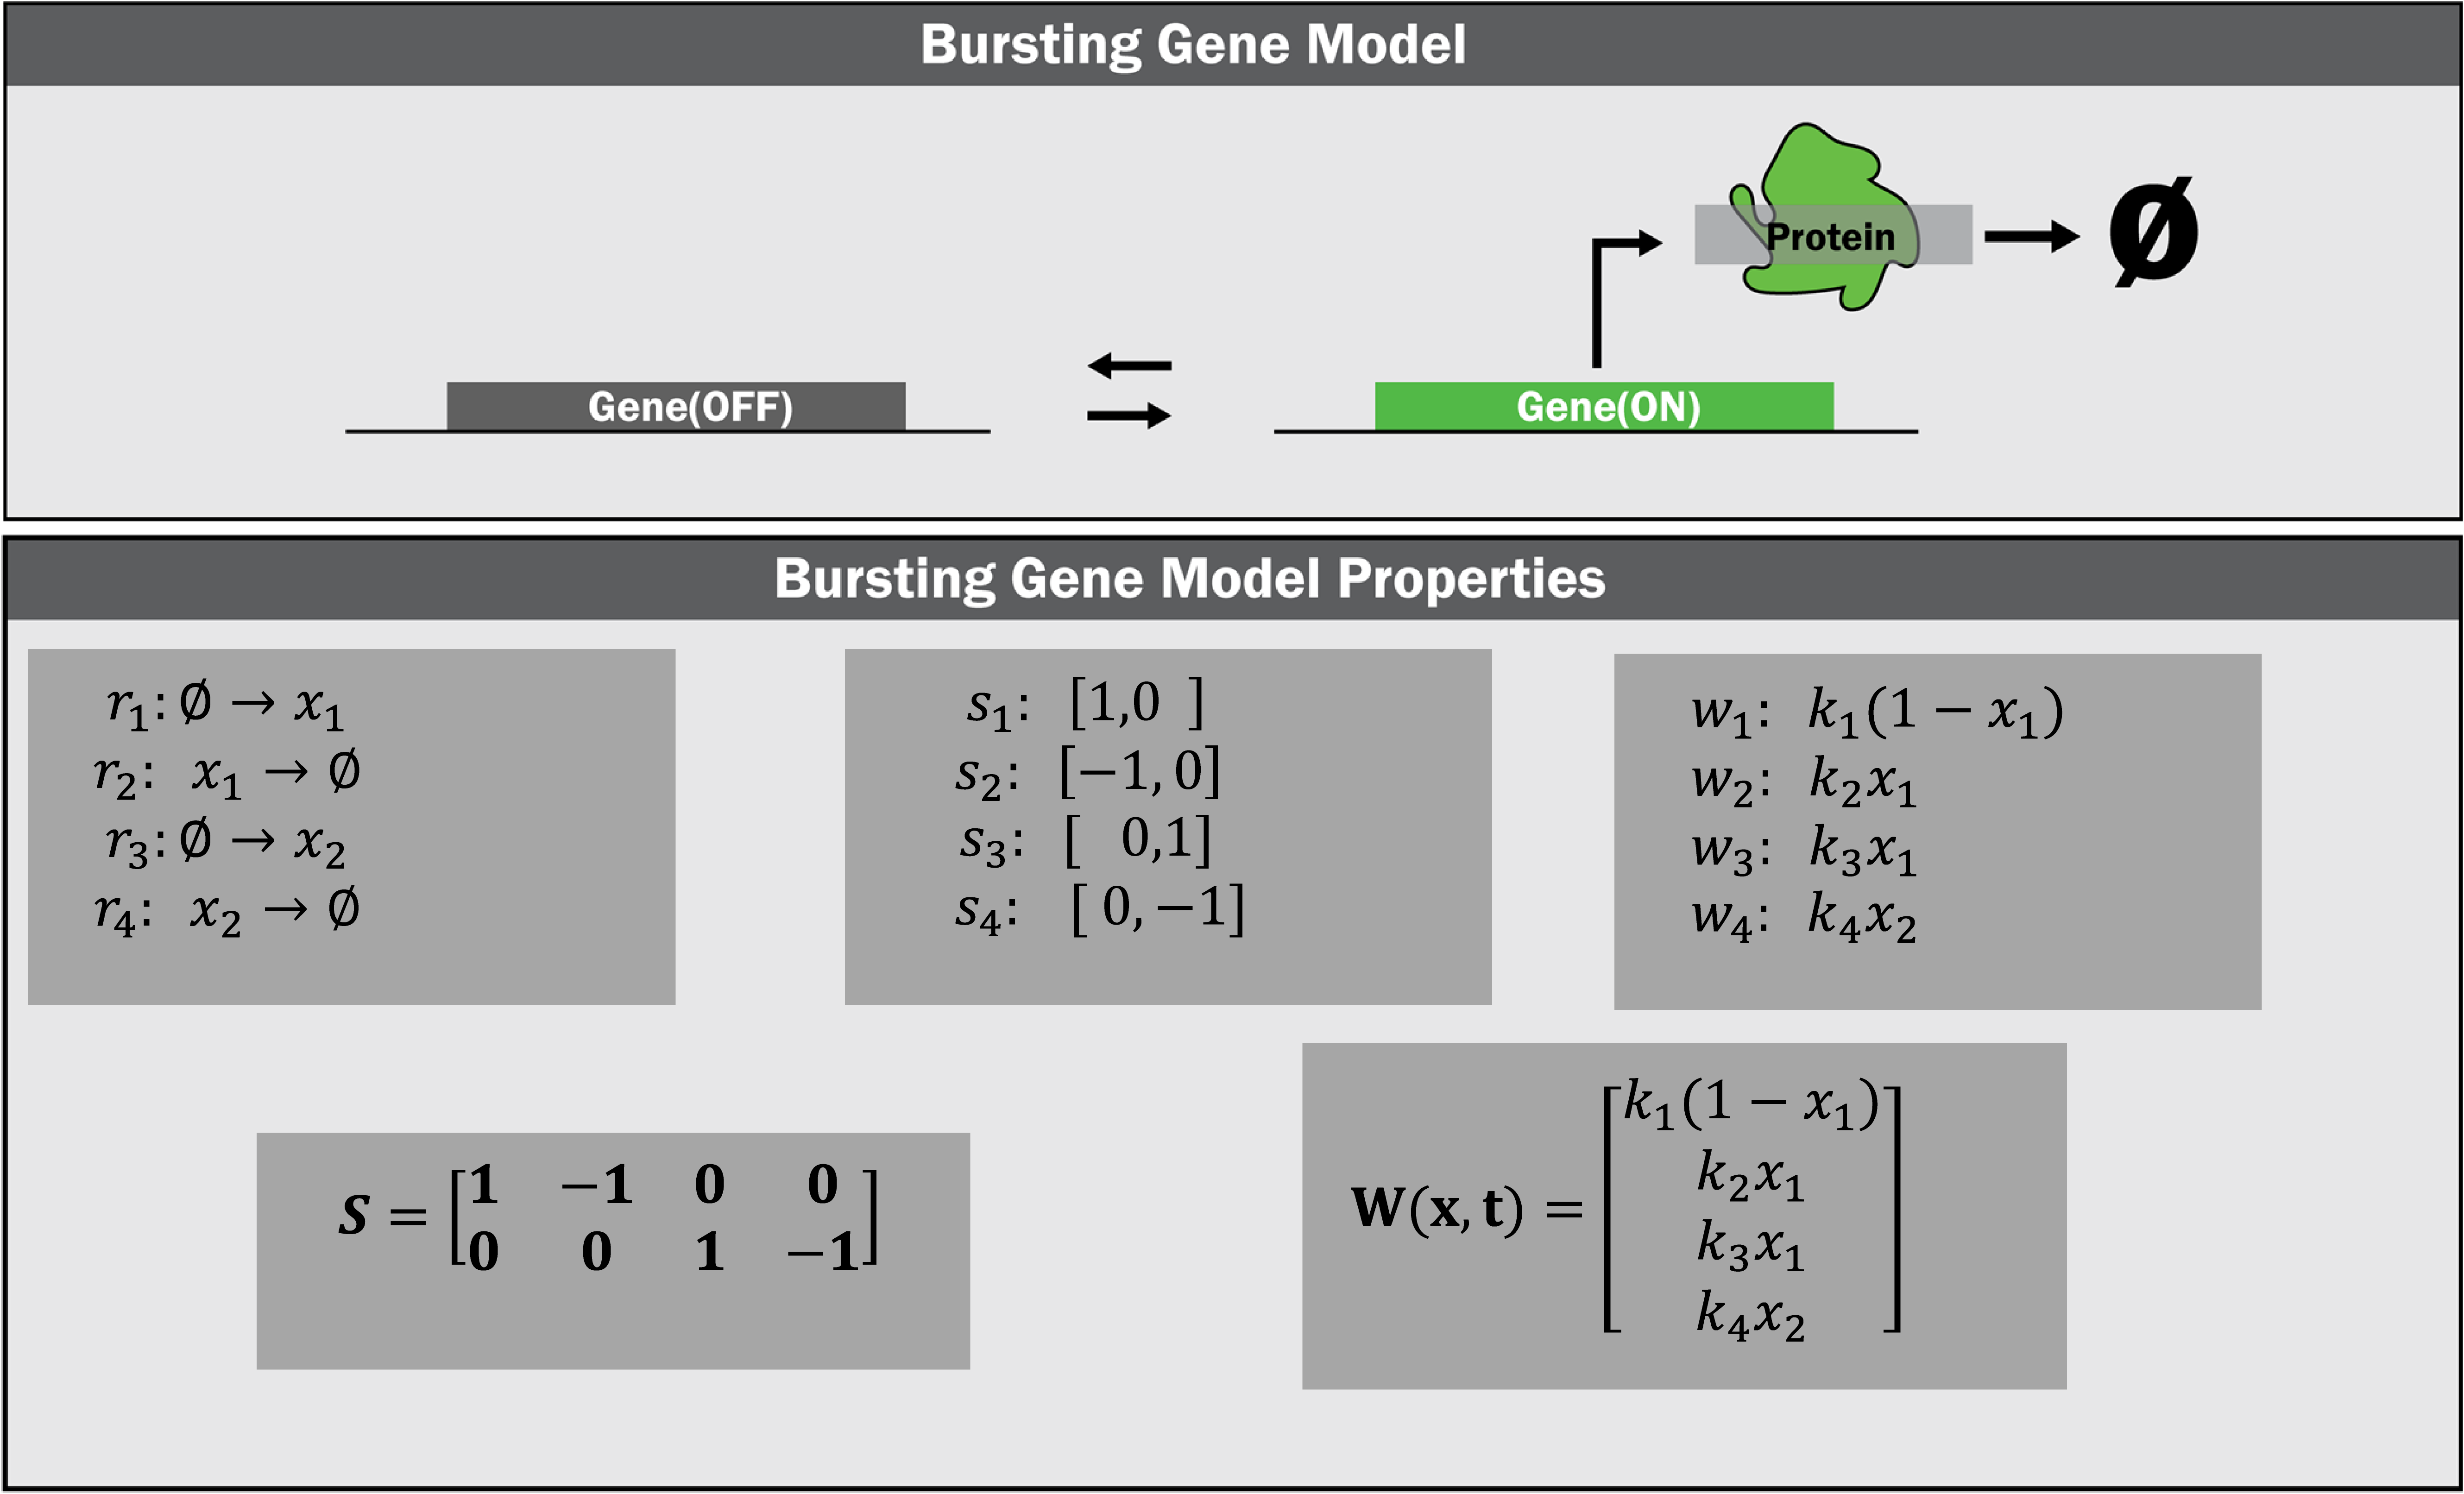

In [82]:
#@title
Image('/content/figures/Bursting.png',width=figSize)

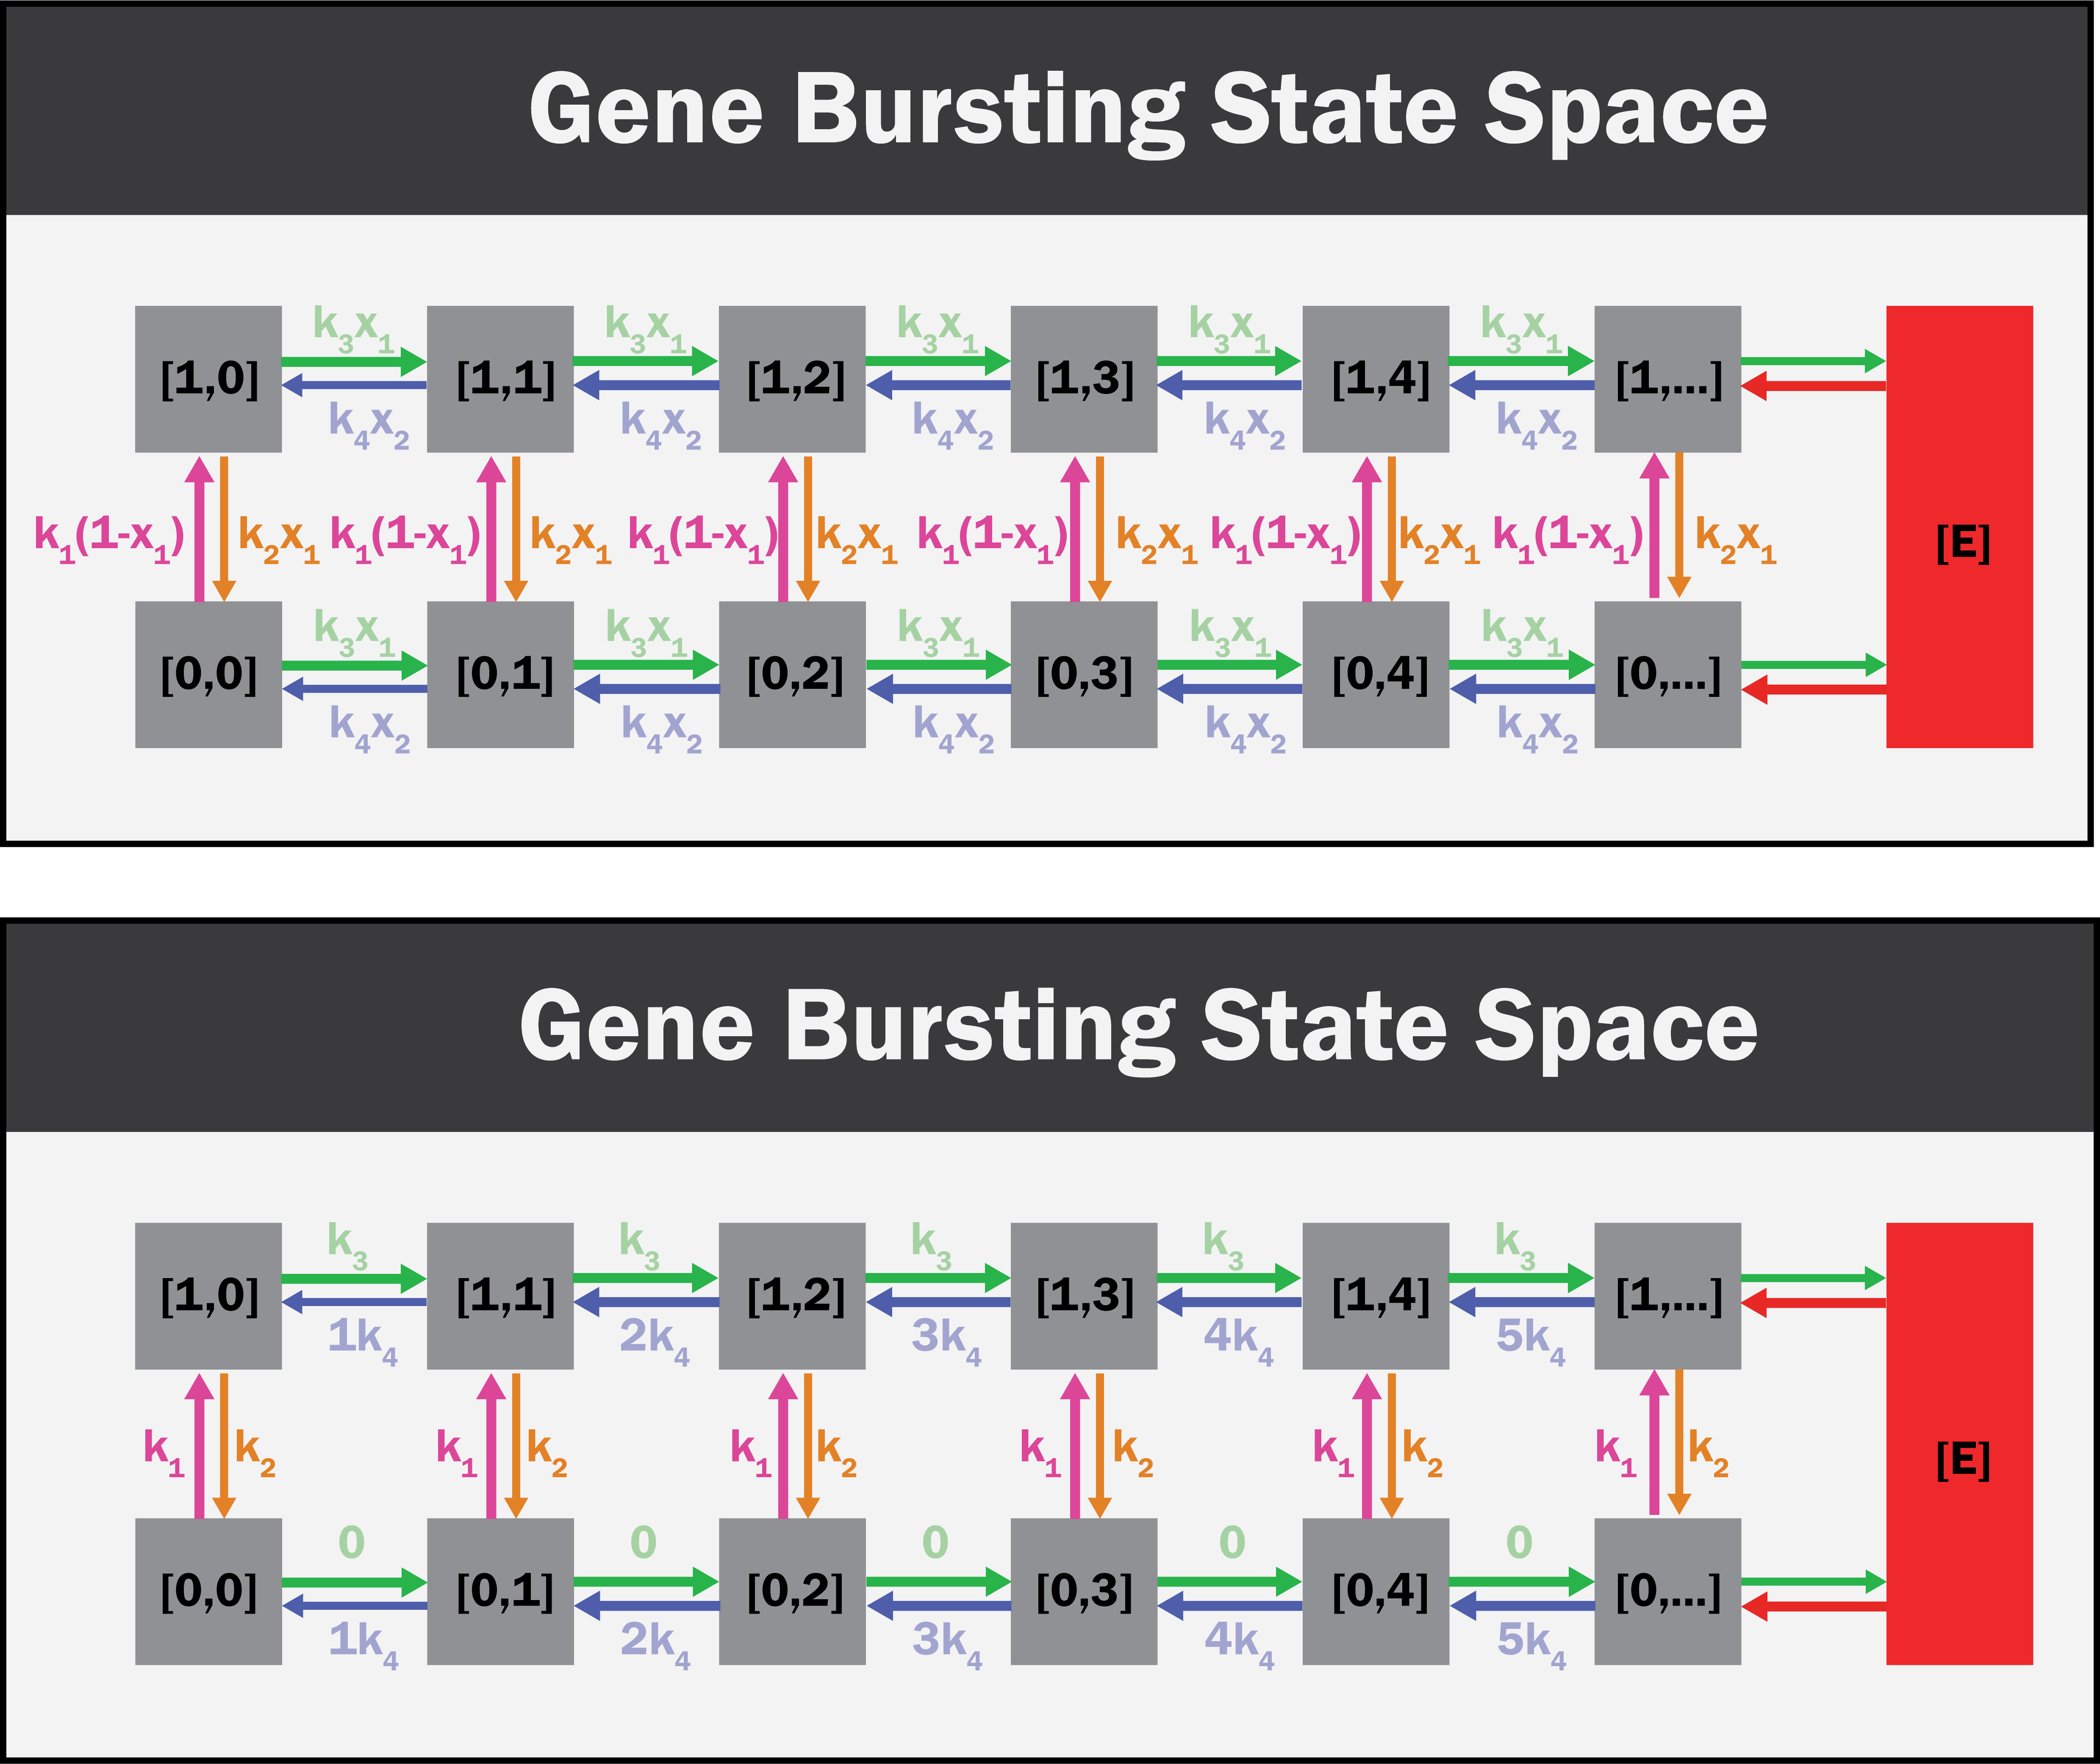

In [83]:
#@title
Image('/content/figures/GeneBurstingStateSpace.png',width=figSize)

---

**Part 1. Create a model by defining time, stoichimetry, propensity and initial state, and parameters, and solve for the model using solveFSP(time,initialState,stoichiometry, propensity, parameters,sink=True, isTimeVarying=False)**

---

In [93]:
numStates=5
finalTime=200
time = np.linspace(0, finalTime,100)
initialState = np.zeros([2*numStates])
initialState[0]=1
def propensity(t, x, k): 
  rate= np.array([k[0]*(1-x[0]),      # Gene OFF to Gene ON 
                  k[1]*x[0],          # Gene ON to Gene OFF 
                  k[2]*x[0],          # Gene ON and Makes Protrin
                  k[3]*x[1]])         # Protein Decay
  return rate
stoichiometry = np.array([[ 1, -1,  0,  0],
                          [ 0,  0,  1, -1]])   
parameters = np.array([0.05, 0.015, 5.0, 0.05])
(time,state)=solveFSP(time,initialState,stoichiometry,propensity,parameters,[2,numStates],sink=True,isTimeVarying=False)
error=state[:,-1]
print("Error: %s" % (error[-1] ))
print(state.shape)

Error: 0.999944258414407
(100, 11)


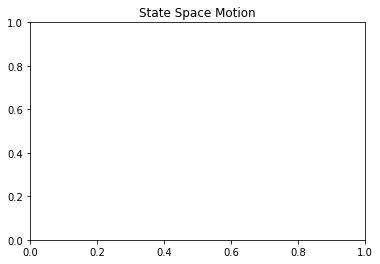

In [85]:
#@title
fig=plt.figure(figsize=(6,4))
ax = plt.axes()
def frame(w):
    ax.clear()
    global time,state,numStates
    plt.title("State Space Motion")
    ax.set_xlabel('X(t)')
    ax.set_xlim(-1,numStates)
    ax.set_ylabel('Y(t)')
    xRange=range(len(state[w,:numStates:]))
    plot=ax.step(xRange,state[w,0:numStates:],'r-')
    plot=ax.step(xRange,state[w,(numStates):-1:],'b-')
    plot=ax.step(xRange,state[w,(numStates):-1:]+state[w,:numStates:],'g-')
    ax.legend(['Protein and Gene Off','Protein and Gene On','Protein'])
    return plot
anim = animation.FuncAnimation(fig, frame, frames=100, blit=False, repeat=True)
plt.close(fig)
anim

---
**Part 2.  Use makeInfGenerator(stoichiometry,propensity,parameters,dimensions) to create an inf Generator of the bursting gene model, and use the function to calulate the steady state and the relaxation time of the system. Change the sink property of the function and resolve for the steadystate solution.**

 ---

In [ ]:
infGenerator=makeInfGenerator(stoichiometry,propensity,parameters,[2,numStates],sink=False)
# Use the space below to calulate the eigenvalues and eigenvectors of A, 
# and the steady state distibution of dP/dt=AP



Pss
plt.plot(Pss[0:numStates])
plt.plot(Pss[numStates:2*numStates])

**Use the steady state solution to solve for the probability of Gene on, the probability of the Gene off, and the probability of protein in the system all at steady state.**

In [ ]:
Pss=np.reshape(Pss,[2,numStates])
# Use the Reshapped Pss to calculate information about the probability of total 
# protein and the probability of Gene On and Gene Off



**Workbook Completion Requirements:**
To obtain credit for this workbook, each student should:
* Complete the blanks in all three problems of the problems in the main notebook and answer at least 3 questions from Q1-Q6 below.

To obtain a certificate for the course, you must complete a minimum of five notebooks from Modules 1-4 (please note that preliminary notebooks from Module 0 will not be accepted) and submit them together via email before August 15, 2022. Please submit your completed notebooks to qbio_summer_school@colostate.edu
 

---

# **Comments**

https://www.atmos.colostate.edu/~munsky/Papers/JChemPhys_124_044104.pdf

__Q1__ — The fact that the column sum of the infinitesimal generator is zero tells us that there is an eigenvalue exactly equal to zero. Please explain why? (Hint — can you find a left Eigenvector?)

__Q2__ - What is the meaning of the right eigenvector of the infinitesimal generator?

__Q3__ - Why does the propensity function increase with the number of molecules?  Can you think of a situation where this may not be the case (e.g., at very high levels of proteins)? 

__Q4__ - The slowest part of the provided FSP code is the calculation of expm(A*t) at each time step. Can you think of a way to solve the time invariant FSP by taking only a single matrix exponential? 

__Q5__ - Using the FSP code, how could you compute the median first time at which there are >20 proteins? 

__Q6__ - The 0-associated eigenvector is always real! Show that the zero-eigenvector of A is also an eigenvector of expm(A). What is the eigenvalue corresponding to this eigenvector for expm(A)? 
Hint1 : What is: expm(A)*Pss? 
Hint2: What is the column sum of expm(A)? 

__For further thought__ - For higher dimension problems with more chemical species, there are simple methods to use multiple sinks and explore in a systematic manner — e.g., expand in the direction where the probability mass has left. 
Here is an example paper that looks at lots of these is 
Issues: https://www.engr.colostate.edu/~munsky/Papers/Munsky_JCompPhys_2007.pdf 

